# PyTorch: Autoencoder convolucional Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [1]:
# 1.0)
!pip3 install torch torchvision torchaudio torchviz

In [2]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [3]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [4]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [5]:
# 1.4)
import google.colab
from google.colab import files

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [7]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.8MB/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 165kB/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.09MB/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 13.0MB/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



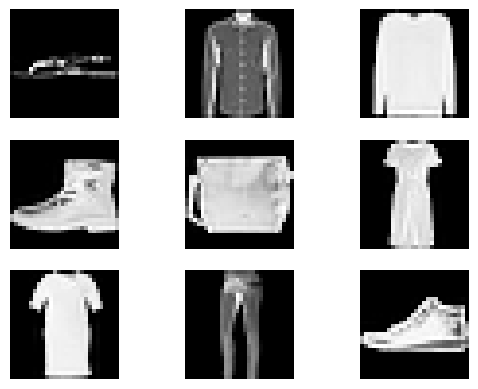

In [8]:
# 2.2)
figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(train_set_orig),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = train_set_orig[j]
    figure.add_subplot(rows,cols,i)
    #plt.title(labels_names[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

## Ejercicio 3) Creando un `DataSet` personalizado.

**1)** Con el fin de implementar un autoencoder, cree una clase derivada de la clase `DataSet` (llámela, por ejemplo `CustomDataset`) que, en vez de retornal el label asociado a cada imagen de `FashionMNIST`, retorne la imagen misma.

**2)** Utilice dicha clase para transformar los conjuntos de entrenamiento y testeo de `FashionMNIST` pensados para clasificación, a correspondientes conjuntos pensados para entrenar un autoencoder.
Para ello, defina una clase `CustomDataset` que deriva de la clase `Dataset`, cuyo método `__getitem__(self,i)` retorne el pair `input,output` donde tanto `input` cómo `output` son iguales a la $i$-ésima imagen del dataset.

In [9]:
# 3.1)

class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,i):
        image, label = self.dataset[i]
        input = image
        output = image
        return input, output

#Lo que hacemos aqui es especificar que los inputs y outputs serán imagenes, lo cual es necesario en autoencoders
#No buscamos labels, ya que no estamos en un problema de clasificacion

In [10]:
#3.2
#Convertimos Fashion Mnist Dataset a CustomDataset

train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

## Ejercicio 4) Red Neuronal Autoencoder Convolucional

**1)** Defina y cree una red neuronal *autoenconder convolucional* constituida por las siguientes capas:

1. Una capa convolucional 2D constituida por:

* Una capa `Conv2d` (ver https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) que deberá mapear $1$ canal de entradas de dimensiones $(28,28)$ a $16$ canales de de salida de dimensiones $(26,26)$. Para ello utilice un kernel de dimensiones $(3,3)$ y el resto de los parámetros en sus valores por defecto.
* Una capa `ReLU`.
* Una capa `Dropout`.
* Una capa `MaxPool` (ver https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) con un kernel de dimensiones $(2,2)$, de manera que mapeará entradas de dimensiones $(26,26)$ a salidas de dimensiones $(13,13)$.

2. Una capa lineal constituida por:

* Una capa `Flatten` que mapea una entrada de $16$ canales de dimensiones $(13,13)$ a un vector de dimensión $16\times 13\times 13$.
* Una capa `Linear` que mapea un vector de dimensión $16\times 13\times 13$ a un vector de dimensión $n$.
* Una capa `ReLU`.
* Una capa `Dropout`.

3. Una capa capa convolucional 2D transpuesta, constituida por:

* una capa `ConvTranspose2d` (ver https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) que mapea $16$ canales de dimensiones $(13,13)$ a $1$ canal de dimensiones $(28,28)$. Para ello, utilice un kernel de dimensiones $(6,6)$ y un stride de dimensiones $(2,2)$, dejando el resto de los parámetros en sus valores por defecto, i.e. padding de $(1,1)$ y out_padding de $(0,0)$.

* Una capa `Sigmoid`.

**3)** Grafique, a modo de comparación, unas pocas imagenes a predecir vs las correspondientes imagenes predichas utilizando el modelo sin entrenar y dropout $p=0.2$.

In [11]:
# 4.1)
def convt2d_z_out(z_in, stride, padding, dilation, kernel_size, output_padding):
    z_out = (z_in - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1
    return z_out

In [12]:
# PROBAMOS CON LOS DATOS DEL INCISO:
convt2d_z_out(13,2,1,1,6,0)

28

In [13]:
class Autoencoder(nn.Module):
  def __init__(self, p=0.2):
    super(Autoencoder, self).__init__()
    self.flatten = nn.Flatten()
    #ENCODER
    self.Conv2d = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Dropout(p),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.Linear = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=16*13*13, out_features=16*13*13),
        nn.ReLU(),
        nn.Dropout(p),
    )
    #DECODER
    self.convt2d = nn.Sequential(
        nn.Unflatten(dim=1, unflattened_size=(16, 13, 13)),
        nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=6, stride=2, padding=1),
        nn.Sigmoid(),
    )
  def forward(self, x):
    x = self.Conv2d(x)
    x = self.Linear(x)
    x = self.convt2d(x)
    return x

In [14]:
# 4.2 CREAMOS EL MODELO

p = 0.2
model = Autoencoder(p=p)

In [15]:
#Create a dummy input tensor
image = torch.randn(1,1,28,28)
output = model(image)
print(f"Input size: {image.size()}")
print(f"Output size: {output.size()}")


Input size: torch.Size([1, 1, 28, 28])
Output size: torch.Size([1, 1, 28, 28])


In [16]:
def batch(x):
  return x.unsqueeze(0)

def unbatch(x):
  return x.squeeze().detach().cpu().numpy()

In [17]:
image, _ = train_set[0]
batched_image = batch(image)
print("batched_size_image: ", batched_image.size())

pred_batched_image = model(batched_image)
print("pred_batched_size_image: ", pred_batched_image.size())

pred_image = unbatch(pred_batched_image)
print("pred_size_image: ", pred_image.shape)




batched_size_image:  torch.Size([1, 1, 28, 28])
pred_batched_size_image:  torch.Size([1, 1, 28, 28])
pred_size_image:  (28, 28)


POR QUE USO SHAPE EN LUGAR DE SIZE: Función unbatch:

Esta función convierte el tensor de PyTorch en un array de NumPy. Al hacerlo, se pierde el método .size() que es propio de los tensores de PyTorch.

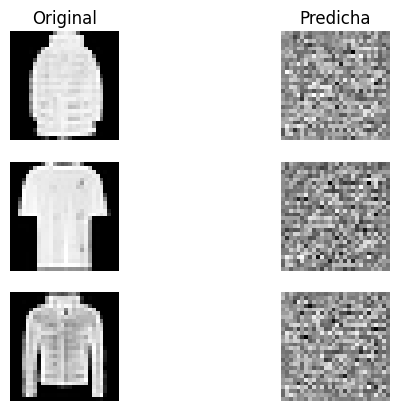

In [18]:
# AHORA VAMOS A VER LAS IMAGENES QUE PRODUCE EL MODELO SIN ENTRENAR

#Creamos una figura para guardar los graficos y definimos la cuadricula de 3*2
figure = plt.figure()
rows, cols = 3,2
i = 0


#Creo un bucle para generar los subplots
#image, _ = train_set[j]: Obtiene una imagen aleatoria del conjunto de entrenamiento (train_set). Aquí, _ ignora la etiqueta asociada (si la hubiera)

for row in range(1, rows+1):
  j = torch.randint(len(train_set),size=(1,)).item()
  i +=1
  image, _ = train_set[j]
  figure.add_subplot(rows,cols,i)
  if row == 1:
    plt.title("Original")
  plt.axis("off")
  plt.imshow(unbatch(image),cmap="Greys_r")

  i += 1
  figure.add_subplot(rows,cols,i)
  if row == 1:
    plt.title("Predicha")
  plt.axis("off")
  image_pred = unbatch(model(batch(image)))
  plt.imshow(image_pred,cmap="Greys_r")

plt.show()

## Ejercicio 5) Entrenando el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de prueba o validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` que estén definidos sobre  el `train_set` (conjunto de entranmiento) y el `valid_set` (conjunto de prueba) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando el **Error Cuadrático Medio**.

**5)** Cree un optimizador con un learning rate igual a $10^{-3}$.
Pruebe con **ADAM**.

**6)** Cree una instancia del modelo con dropout $p=0.2$.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop que itere sobre épocas de entrenamiento y validación, y que guarde en listas correspondientes los siguientes valores del **ECM**:
*  promedios (incorrectos) sobre el conjunto de entrenamiento, calculado **durante** el proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de entrenamiento, calculados **posteriormente** al proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de validación, calculados **posteriormente** al proceso de entrenamiento sobre la época.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso **8)** para graficar en función de las **épocas de entrenamiento** el **ECM** de **entrenamiento** y **validación**, respectivamente.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Grafique, comparativamente, algunas de las imagenes a predecir vs las imagenes predichas por el modelo entrenado.

**12)** Repita para otras elecciones de los hiperparámetros tales como, el optimizador (podría ser el **SGD**), el **learning-rate**, el tamaño de los **batchs**, el **dropout**, **capas convolucionales** y **convolucionales traspuestas** de otros tamaños.
En particular, pruebe eliminando, adecuadamente, la **capa lineal**.
Que valores de estos hiperparámetros considera los más convenientes? Porqué?

In [19]:
# 5.1)

#Definimos la funcion de entrenamiento
def train_loop(dataloader, model, loss_fn, optimizer, verbose = True):
    model.train()  # Activamos el modo de entrenamiento
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    num_processed_samples = 0

    #Movemos el modelo a la gpu si es que está disponible
    model = model.to(device)
    #Iteramos sobre los lotes
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      batch_size = len(X)
      num_processed_samples += batch_size
      #Calculamos la prediccion del modelo y la funcion de perdida correspondiente
      pred = model(X)
      loss = loss_fn(pred,y)
      #Backpropagamos usando el optimizador atribuido
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #Calculamos la perdida promedio del batch y lo agregamos a una suma correspondiente
      batch_avrg_loss = loss.item()
      sum_batch_avrg_loss += batch_avrg_loss
      #Reportamos el proceso
      if batch % (num_batches/10) == 0 and verbose:
        current = batch * len(X)
        print(f"loss: {batch_avrg_loss:>7f}  [{current:>5d}/{num_samples:>5d}]")

    avg_loss = sum_batch_avrg_loss/num_processed_samples
    return avg_loss


In [22]:
# HACER EL LOOP DE VALIDACION
def eval_loop(dataloader, model, loss_fn):
    # Desactivamos la maquinaria de entrenamiento del modelo
    model.eval()

    # Definimos ciertas constantes
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    num_processed_samples = 0

    # Movemos el modelo a la GPU si es que está disponible
    model = model.to(device)

    # Para testear, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X, y in dataloader:
            # Copiamos las entradas y las salidas al dispositivo de trabajo si es que está disponible
            X = X.to(device)
            y = y.to(device)
            batch_size = len(X)  # Número de muestras en el lote
            num_processed_samples += batch_size

            # Calculamos las predicciones del modelo...
            pred = model(X)
            loss = loss_fn(pred, y)

            # Calculamos la pérdida promedio del batch y lo agregamos a una suma correspondiente.
            batch_avrg_loss = loss.item()
            sum_batch_avrg_loss += batch_avrg_loss

        # Calculamos la pérdida total promedio dividiendo entre el número de batches
        avg_loss = sum_batch_avrg_loss / num_batches

        # Imprimimos el resultado (opcional)
        # print(f"@eval_loop avg_loss={avg_loss:>.8f}")

    return avg_loss


In [24]:
# CREO LOS DATA LOADERS

batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle = True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle = True)

num_train_batches = len(train_loader)
num_valid_batches = len(valid_loader)

print(f"Number of train batches: {num_train_batches}")
print(f"Number of valid batches: {num_valid_batches}")



Number of train batches: 600
Number of valid batches: 100


In [25]:
#5.4
#Creo una instancia de una funcion de perdida, en este caso una entropy loss

#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss() #Para el autoencoder

In [26]:
# 5.5
#Creamos el modelo
p = 0.2
model = Autoencoder(p=p)

In [27]:
#5.6
#Creamos un optimizador, con Stocastic Gradient Descent o un ADAM

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,eps =1e-08,weight_decay=0,amsgrad=False)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [28]:
#5.7
#Determinamos en que dispositivo vamos a trabajar, en una CPU o GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Pasamos el modelo al dispositivo
model = model.to(device)

In [29]:
# 5.8) y 5.9)
# Finalmente, entrenamos iterando sobre épocas.
# Además, testeamos el modelo en cada una de ellas.

num_epochs = 30
list_avg_train_loss_incorrecta = []
list_avg_train_loss = []
list_avg_valid_loss = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}----------------------------")
    avg_train_loss_incorrecta = train_loop(train_loader, model, loss_fn, optimizer)
    avg_train_loss = eval_loop(train_loader, model, loss_fn)
    avg_valid_loss = eval_loop(valid_loader, model, loss_fn)

    list_avg_train_loss_incorrecta.append(avg_train_loss_incorrecta)
    list_avg_train_loss.append(avg_train_loss)
    list_avg_valid_loss.append(avg_valid_loss)

    print("avg_train_loss_incorrecta:", avg_train_loss_incorrecta)
    print("avg_train_loss:", avg_train_loss)
    print("avg_valid_loss:", avg_valid_loss)

print("Done!")


Epoch 1----------------------------
loss: 1.342495  [    0/60000]
loss: 0.651838  [ 6000/60000]
loss: 0.651268  [12000/60000]
loss: 0.607005  [18000/60000]
loss: 0.626269  [24000/60000]
loss: 0.605873  [30000/60000]
loss: 0.599319  [36000/60000]
loss: 0.623476  [42000/60000]
loss: 0.599372  [48000/60000]
loss: 0.616635  [54000/60000]
avg_train_loss_incorrecta: 0.006205200094978014
avg_train_loss: 0.5925673464934031
avg_valid_loss: 0.5902334594726563
Epoch 2----------------------------
loss: 0.590298  [    0/60000]
loss: 0.581239  [ 6000/60000]
loss: 0.588787  [12000/60000]
loss: 0.587179  [18000/60000]
loss: 0.599281  [24000/60000]
loss: 0.589062  [30000/60000]
loss: 0.575274  [36000/60000]
loss: 0.591505  [42000/60000]
loss: 0.589704  [48000/60000]
loss: 0.587467  [54000/60000]
avg_train_loss_incorrecta: 0.005921285474300385
avg_train_loss: 0.5862320095300675
avg_valid_loss: 0.5839496970176696
Epoch 3----------------------------
loss: 0.593576  [    0/60000]
loss: 0.611280  [ 6000/600

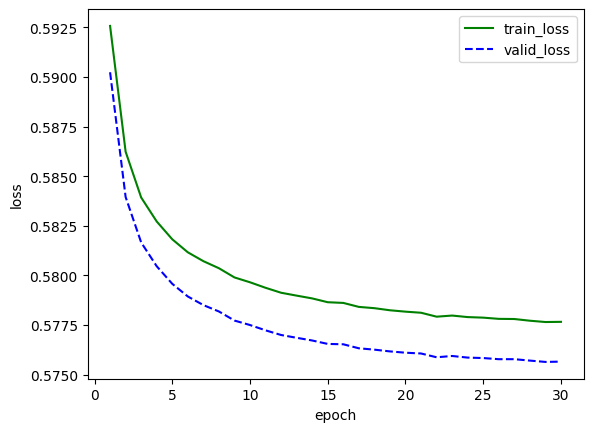

In [31]:
#5.10
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.plot(list(range(1,len(list_avg_train_loss_incorrecta)+1)),list_avg_train_loss_incorrecta,label="train_loss_incorrecta", linestyle="-", c="red")
plt.plot(list(range(1,len(list_avg_train_loss)+1)),list_avg_train_loss, label="train_loss", linestyle="-", c="green")
plt.plot(list(range(1,len(list_avg_valid_loss)+1)),list_avg_valid_loss, label="valid_loss", linestyle="--", c="blue")
plt.legend()
plt.show()

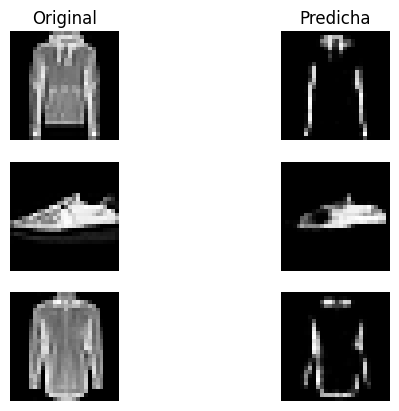

In [36]:
# Miramos ahora las imagenes que predice el modelo
#5.11
figure = plt.figure()
row,cols = 3,2
i = 0
model.eval()
for row in range(1, rows+1):
  j = torch.randint(len(train_set),size=(1,)).item()
  i += 1
  image, flatten_image = train_set[j]
  image = image.to(device)
  figure.add_subplot(rows,cols,i)
  if row == 1:
    plt.title("Original")
  plt.axis("off")
  plt.imshow(unbatch(image),cmap="Greys_r")

  i += 1
  figure.add_subplot(rows,cols,i)
  if row == 1:
    plt.title("Predicha")
  plt.axis("off")
  pred = unbatch(model(batch(image)))
  plt.imshow(pred,cmap="Greys_r")

plt.show()

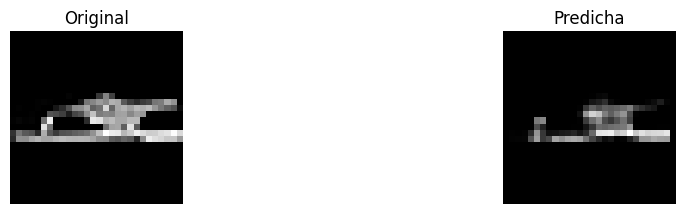

In [33]:
import torch
import matplotlib.pyplot as plt

# Configuramos el dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Movemos el modelo al dispositivo
model = model.to(device)
model.eval()

# Configuramos la figura para graficar
figure = plt.figure(figsize=(10, 6))  # Ajustar tamaño de la figura
rows, cols = 3, 2  # Tres filas y dos columnas para gráficos comparativos
i = 0  # Índice de la subtrama

# Iteramos sobre el número de imágenes a graficar (3 pares: original vs predicha)
for row in range(1, rows // 2 + 1):
    # Seleccionamos una imagen aleatoria del conjunto de entrenamiento
    idx = torch.randint(len(train_set), size=(1,)).item()
    image, label = train_set[idx]  # Obtenemos imagen y etiqueta (original)

    # Añadimos la imagen original al gráfico
    i += 1
    figure.add_subplot(rows, cols, i)
    plt.title("Original") if i == 1 else None  # Título solo en la primera fila
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")  # Graficar imagen original

    # Movemos la imagen al dispositivo adecuado
    image = image.to(device)

    # Obtenemos la predicción del modelo
    with torch.no_grad():
        pred_image = model(image.unsqueeze(0))  # Pasamos la imagen al modelo
        pred_image = pred_image.cpu().squeeze().detach().numpy()  # Convertimos a numpy en CPU

    # Añadimos la imagen predicha al gráfico
    i += 1
    figure.add_subplot(rows, cols, i)
    plt.title("Predicha") if i == 2 else None  # Título solo en la primera fila
    plt.axis("off")
    plt.imshow(pred_image, cmap="gray")  # Graficar imagen predicha

# Ajustamos el diseño del gráfico y mostramos
plt.tight_layout()
plt.show()
